来自kaggle的note,写论文的时候在最前面进行一定的EDA数据分析

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd 
import seaborn as sns
from math import pi
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 

In [2]:
raw_data = pd.read_csv('csv_building_structure.csv')

In [3]:
raw_data.dropna(inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762094 entries, 0 to 762105
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             762094 non-null  int64 
 1   district_id                             762094 non-null  int64 
 2   vdcmun_id                               762094 non-null  int64 
 3   ward_id                                 762094 non-null  int64 
 4   count_floors_pre_eq                     762094 non-null  int64 
 5   count_floors_post_eq                    762094 non-null  int64 
 6   age_building                            762094 non-null  int64 
 7   plinth_area_sq_ft                       762094 non-null  int64 
 8   height_ft_pre_eq                        762094 non-null  int64 
 9   height_ft_post_eq                       762094 non-null  int64 
 10  land_surface_condition                  762094 non-null 

In [4]:
raw_data = raw_data.astype({'district_id': 'object', 'vdcmun_id': 'object', 'ward_id': 'object'})

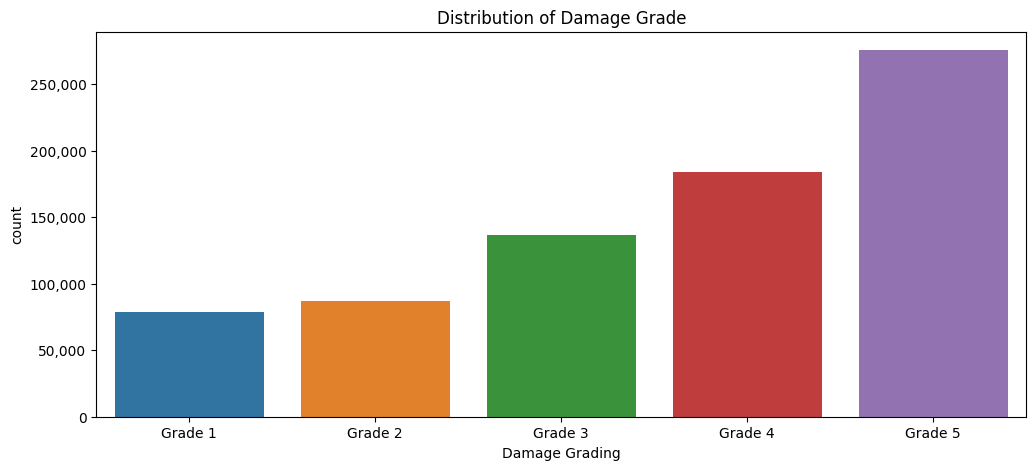

In [5]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=raw_data, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

##### 可以看到数据集是不平衡的

## EDA for structure data set

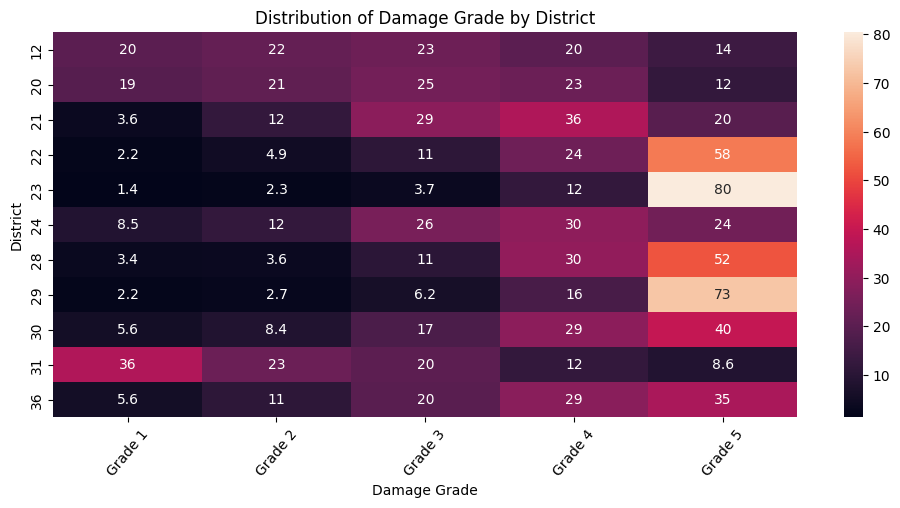

In [12]:
df_temp = raw_data.groupby(['district_id','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['district_id', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['district_id'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
plt.title("Distribution of Damage Grade by District")
plt.xlabel("Damage Grade")
plt.ylabel("District")
plt.show()

del df_temp, ax

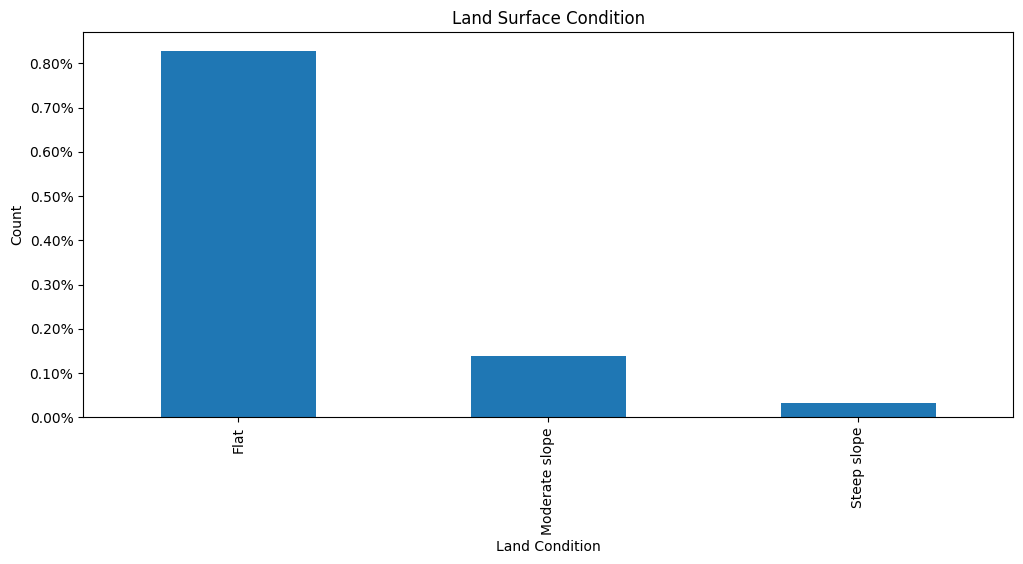

In [14]:
plt.figure(figsize=(12,5))
ax = raw_data.land_surface_condition.value_counts(normalize = True).plot(kind = "bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()

del ax

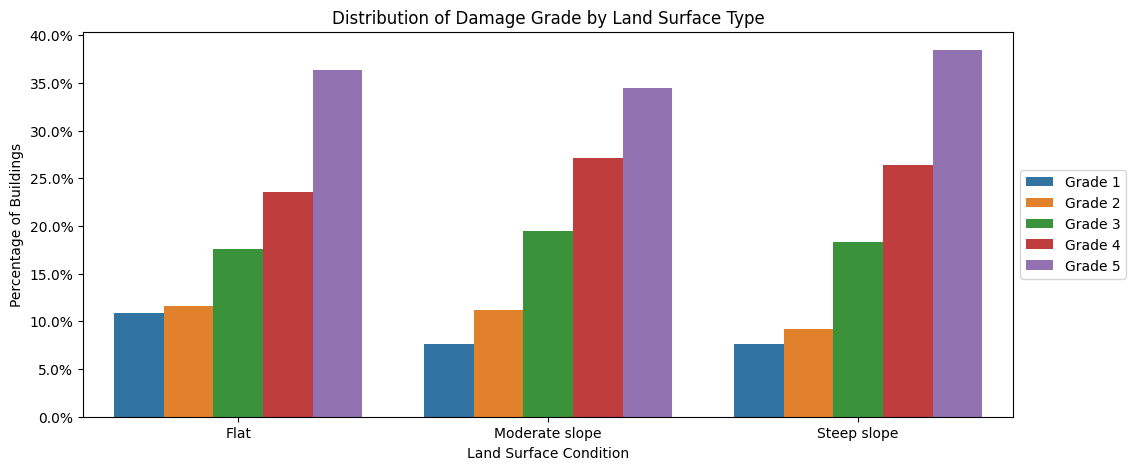

In [15]:
df_temp = raw_data.groupby(['land_surface_condition','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

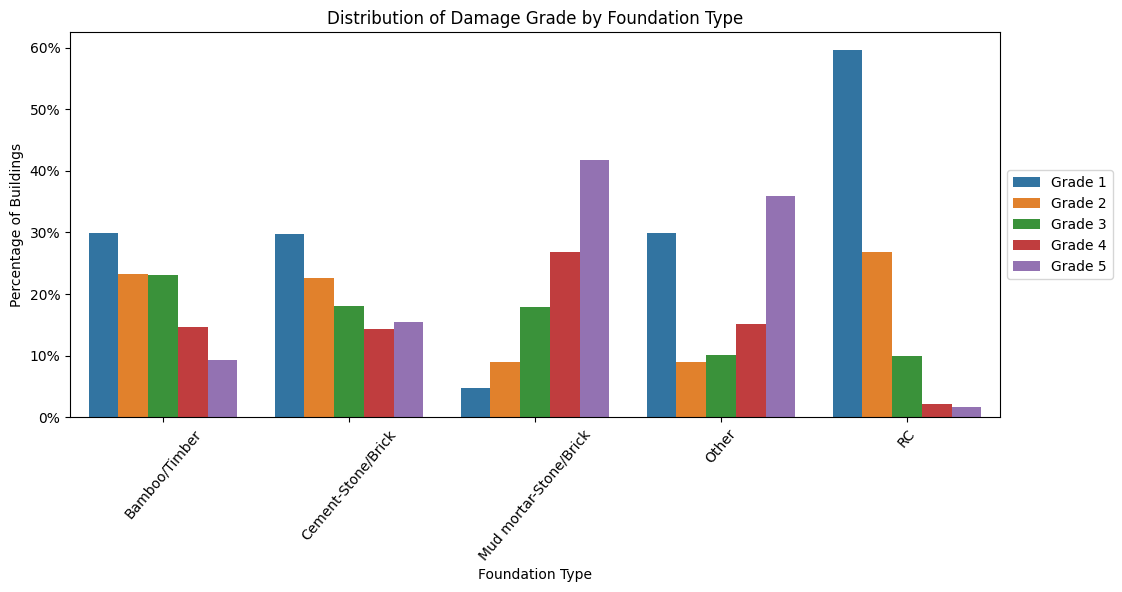

In [16]:
df_temp = df_stru.groupby(['foundation_type','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['foundation_type', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'foundation_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

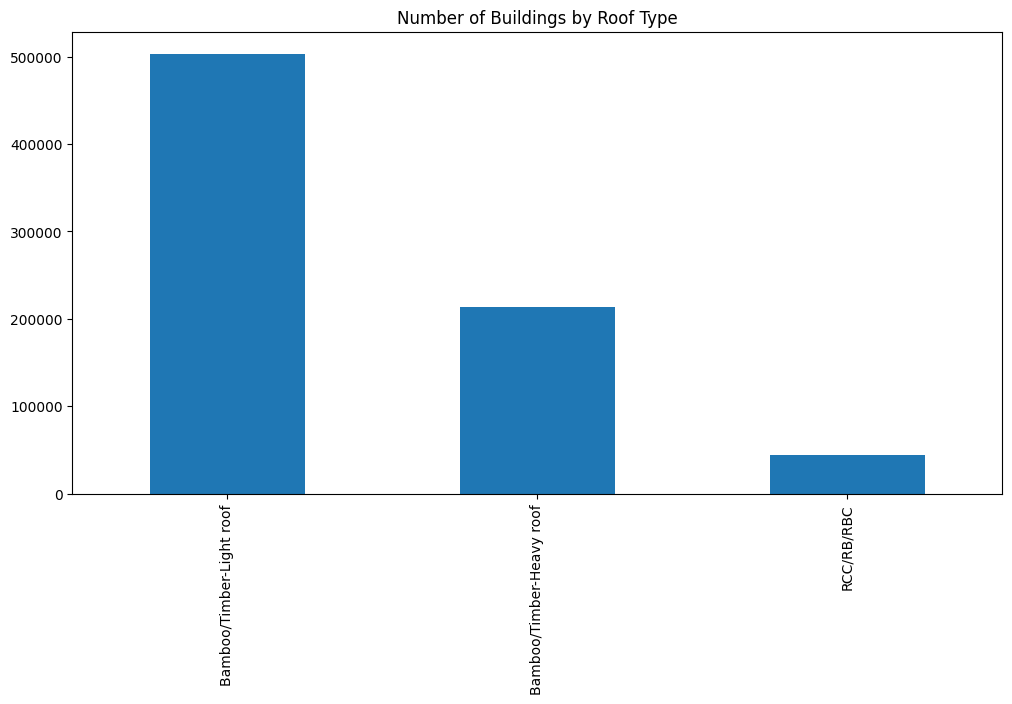

In [18]:
plt.figure(figsize = (12,6))
ax = raw_data.roof_type.value_counts().plot(kind = "bar")
plt.title("Number of Buildings by Roof Type")
plt.show()

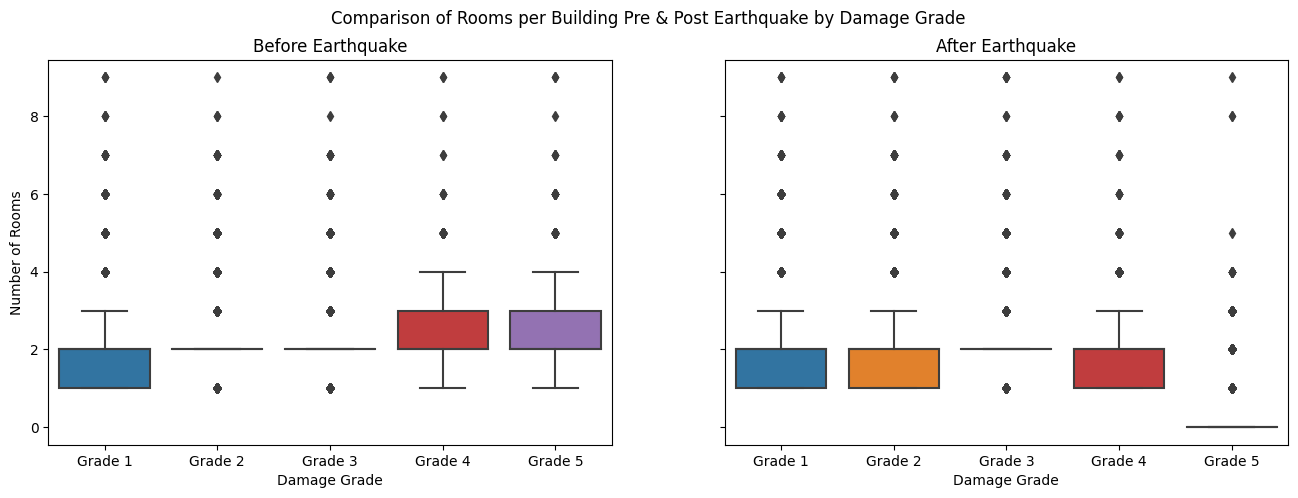

In [19]:
fig, ax = plt.subplots(1,2,figsize = (16,5), sharey='row')
fig.suptitle("Comparison of Rooms per Building Pre & Post Earthquake by Damage Grade")
ax[0].set_title("Before Earthquake")
ax[1].set_title("After Earthquake")
sns.boxplot(data = raw_data, 
            x = "damage_grade", 
            y = "count_floors_pre_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[0])
sns.boxplot(data = raw_data, 
            x = "damage_grade", 
            y = "count_floors_post_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[1])
plt.setp(ax[:], xlabel='Damage Grade')
plt.setp(ax[0], ylabel='Number of Rooms')
plt.setp(ax[1], ylabel=None)
plt.show()

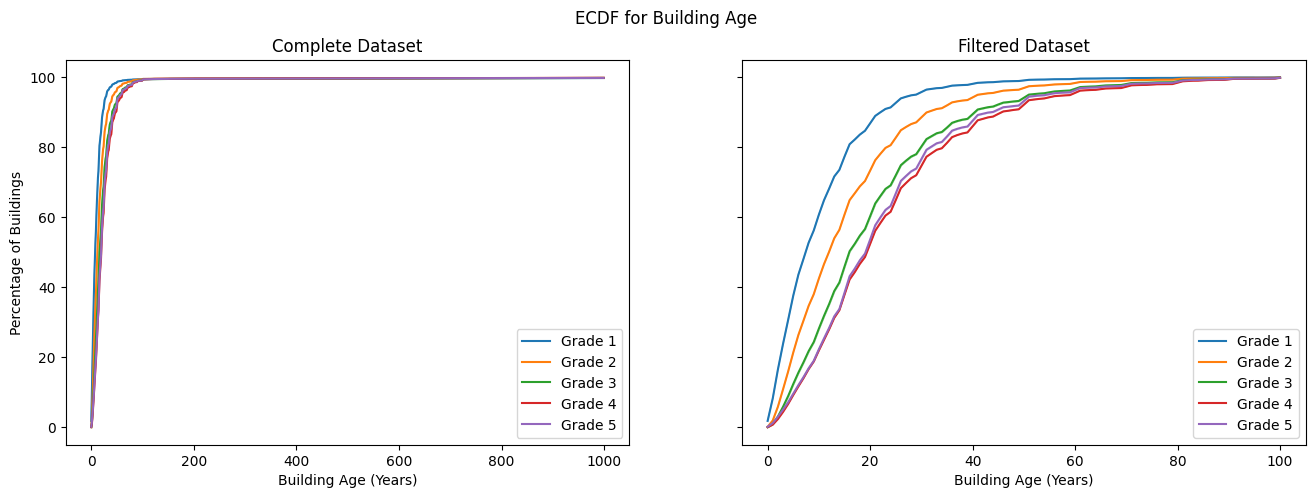

In [20]:
def ecdf(series):
    #This function calculates the ECDF for a series of real numbers
    
    # Number of data points
    n = len(series)
    
    # Sort output
    x = np.sort(series)
    
    # Sequence proportion
    y = np.arange(1, n+ 1) / n * 100
    
    # Return dataframe
    return pd.DataFrame({'x':x, 'y':y})

# List each grade
v_grades = ['Grade ' + str(x) for x in range(1,6)]

# Create a plot template
fig, ax = plt.subplots(1,2, figsize = (16,5), sharey='row')
fig.suptitle("ECDF for Building Age")
ax[0].set_title("Complete Dataset")
ax[1].set_title("Filtered Dataset")

# Create a ecdf for each grade
for grade in v_grades:
    df_temp = df_stru[df_stru.damage_grade == grade] # filter for grade only 
    df_temp = ecdf(df_temp.age_building) # Compute ecdf for grade
    sns.lineplot(data = df_temp, x = 'x', y = 'y', label = grade, ax = ax[0]) # Generate line plot
    del df_temp

# Create a ecdf for each grade - Remove outliers
for grade in v_grades:
    df_temp = df_stru[(df_stru.damage_grade == grade) & (df_stru.age_building <= 100)] # filter
    df_temp = ecdf(df_temp.age_building) # Compute ecdf for grade
    sns.lineplot(data = df_temp, x = 'x', y = 'y', label = grade, ax = ax[1]) # Generate line plot
    del df_temp

# show plot
plt.setp(ax[:], xlabel='Building Age (Years)')
plt.setp(ax[0], ylabel='Percentage of Buildings')
plt.setp(ax[1], ylabel=None)
plt.show()

# Clear objects
del grade, v_grades, fig, ax

D:\anaconda1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


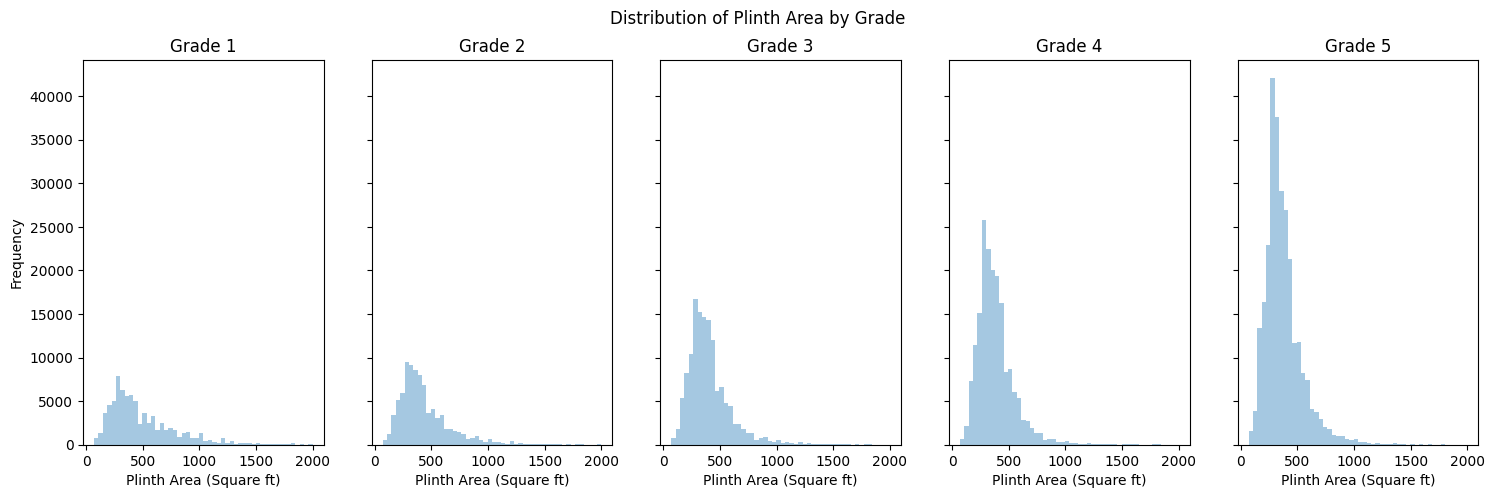

In [21]:
# List of grades
v_grades = ['Grade ' + str(x) for x in range(1,6)]

# Plot structure
fig, ax = plt.subplots(1, 5, figsize=(18,5), sharey="row", sharex="row")
fig.suptitle("Distribution of Plinth Area by Grade")

# Build plot
count = 0
for grade in v_grades:
    df_temp = df_stru[(df_stru.damage_grade == grade) & (df_stru.plinth_area_sq_ft <= 2000)] # filter for grade
    ax[count].set_title(grade)
    sns.distplot(a = df_temp['plinth_area_sq_ft'], label = grade, kde=False, ax=ax[count])
    del df_temp
    count += 1
    
# Plot Aesthetics
plt.setp(ax[:], xlabel='Plinth Area (Square ft)')
plt.setp(ax[0], ylabel='Frequency')
plt.show()

# Clear objects
del grade, v_grades, fig, ax, count


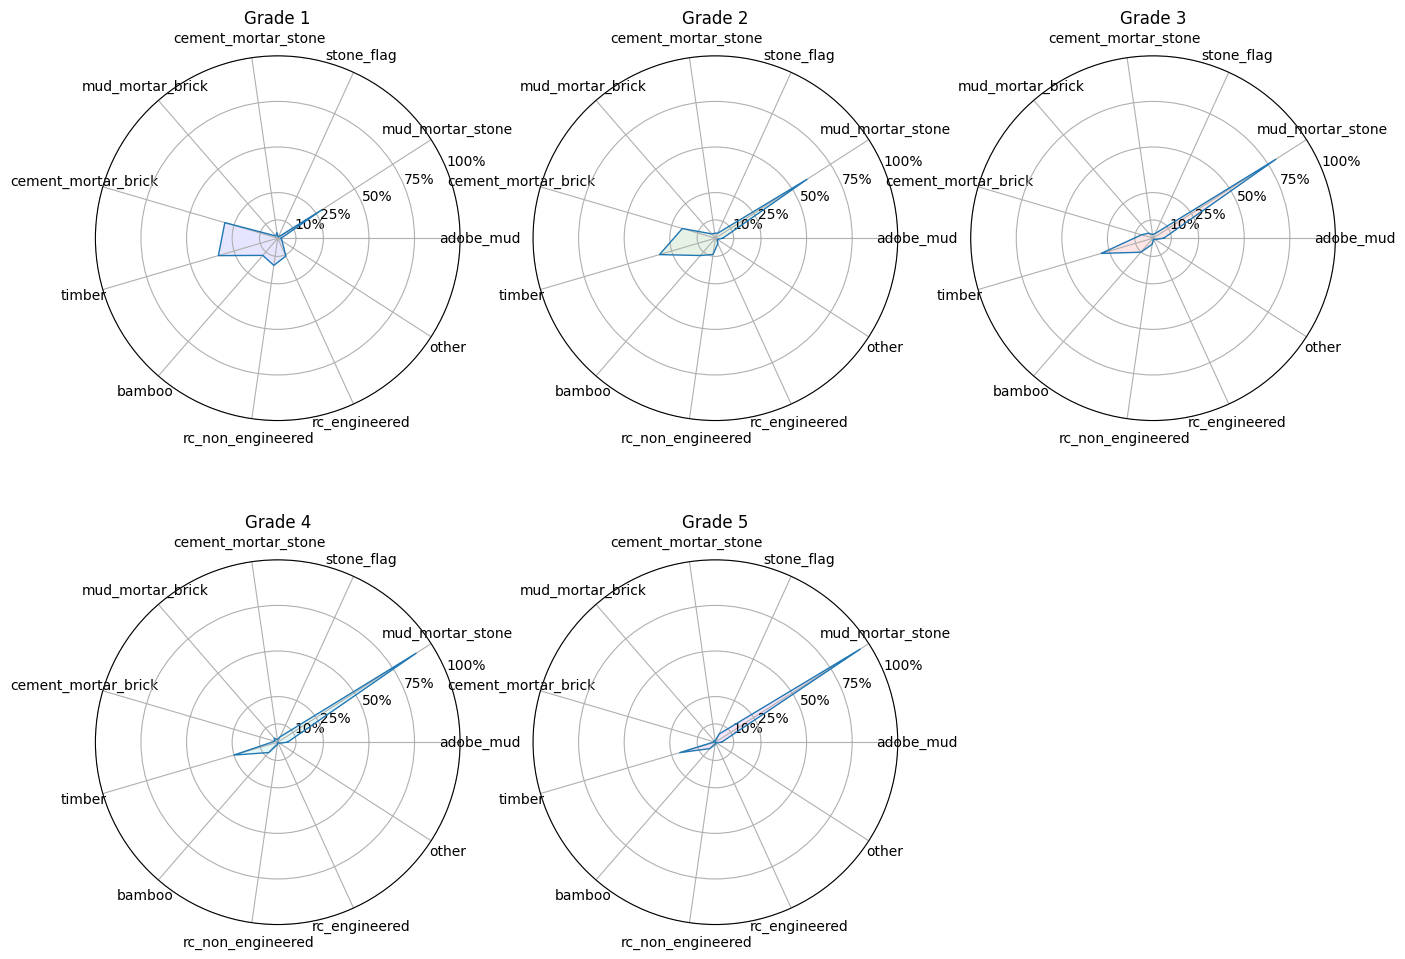

In [24]:
# list of binary columns
v_cols = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
          'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
          'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 
          'has_superstructure_timber', 'has_superstructure_bamboo', 
          'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 
          'has_superstructure_other']

# New Names of Binary Cols
v_names = {'has_superstructure_adobe_mud':'adobe_mud', 
           'has_superstructure_mud_mortar_stone':'mud_mortar_stone',
          'has_superstructure_stone_flag':'stone_flag', 
           'has_superstructure_cement_mortar_stone':'cement_mortar_stone',
          'has_superstructure_mud_mortar_brick':'mud_mortar_brick', 
           'has_superstructure_cement_mortar_brick':'cement_mortar_brick', 
          'has_superstructure_timber':'timber', 
           'has_superstructure_bamboo':'bamboo', 
          'has_superstructure_rc_non_engineered':'rc_non_engineered', 
           'has_superstructure_rc_engineered':'rc_engineered', 
          'has_superstructure_other':'other'}

# Summarise and rename columns
df_temp = df_stru.groupby('damage_grade')[v_cols].agg('mean').reset_index()
df_temp.rename(columns=v_names, inplace = True)

# Lists to use
v_grades = ['Grade ' + str(x) for x in range(1,6)]
v_colour = ['b', 'g', 'r', 'c', 'm']

# number of variables
v_categories = list(df_temp)[1:]
v_N = len(v_categories)

# Angles
v_angles = [n / float(v_N) * 2 * pi for n in range(v_N)]
v_angles += v_angles[:1]

# Initialise the plot
fig, ax = plt.subplots(2,3, figsize = (16,12), subplot_kw=dict(polar=True))

# Format axis
plt.setp(ax, # X
         xticks = v_angles[:-1], 
         xticklabels = v_categories,
         yticks = [0.10,0.25,0.50,0.75,1.0],
         yticklabels = ["10%","25%","50%","75%","100%"],
         ylim = (0,1))

# Populate plot in a loop
count, row, col = 0, 0, 0
for grade in v_grades:   
    values = df_temp.loc[count].drop('damage_grade').values.flatten().tolist()
    values += values[:1]
    ax[row, col].plot(v_angles, values, linewidth=1, linestyle='solid', label=grade)
    ax[row, col].fill(v_angles, values, v_colour[count], alpha=0.1)
    ax[row, col].set_title(grade)

    # Increment counters
    if count >= 2: # Ensure reference correct row
        row = 1
    
    if col < 2: # Ensure reference correct col
        col += 1
    else:
        col = 0
    
    count += 1 # increase count var

# Drop 6th subplot
fig.delaxes(ax[1,2])

# Clear objects
del v_cols, v_names, df_temp, v_grades, v_colour,\
    v_categories, v_N, v_angles, fig, ax, count, row, col, grade

### 特征工程：
#### 关注下面两个特征：1.净房间数(地震后房间数-地震前房间数);2.净高度(地震后建筑高度-地震前建筑高度)

In [25]:
# 增加下面两个变量
raw_data['net_rooms'] = raw_data.count_floors_post_eq - raw_data.count_floors_pre_eq
raw_data['net_height'] = raw_data.height_ft_post_eq - raw_data.height_ft_pre_eq

In [28]:
# 数据分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(raw_data.drop('damage_grade', axis = 1), 
                                                    raw_data['damage_grade'],
                                                    test_size = 0.2, 
                                                    random_state = 1989, 
                                                    stratify = df_stru['damage_grade'],
                                                    shuffle=True)


# Visualise proportions on train and test
pd.merge(y_train.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
         y_test.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
         on = "index",
         how = "left")

,index,train,test
0,Grade 5,0.361853,0.361851
1,Grade 4,0.241235,0.241236
2,Grade 3,0.178995,0.179000
3,Grade 2,0.114497,0.114494
4,Grade 1,0.103419,0.103419


In [29]:
# Target Variable Transformer
preprocessor_tar = LabelEncoder()
y_train = preprocessor_tar.fit_transform(y_train)
y_test = preprocessor_tar.fit_transform(y_test)

# Visualise Counts
pd.DataFrame(y_train).value_counts(normalize = True)

# Clean objects
del preprocessor_tar

In [30]:
# Print x train shape before processing
print("Before preprocessing there were {} rows and {} columns".format(*x_train.shape))

# ------------ Predictor Processing ------------
# Identify columns
fts_cvt_obj = ['district_id', 'vdcmun_id', 'ward_id']
fts_outlier = ['age_building']
fts_cat = raw_data.drop(fts_cvt_obj, axis = 1).select_dtypes(include=['object']).drop('damage_grade', axis = 1).columns
fts_num = raw_data.select_dtypes(np.number).columns

# Convert to object Transformer
def covert_to_object(x):
    '''Converts a column to object'''
    return pd.DataFrame(x).astype(object)
trans_to_object = Pipeline(steps = [('convert_to_object', FunctionTransformer(covert_to_object))])

# Outlier Restriction
trans_outlier = Pipeline(steps = [('Outlier_scaler', RobustScaler(quantile_range = (0,0.9)))])

# Categorical Transformer
trans_cat = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Numerical Transformer
trans_num = Pipeline(steps = [('scaler', StandardScaler()),
                              ('MinMax', MinMaxScaler())])

# Zero or Near Zero variance
trans_nzv = Pipeline(steps = [('nzv', VarianceThreshold(threshold = 0.01))])

# Create a single Preprocessing step for predictors
preprocessor_preds = ColumnTransformer(
    transformers=[
        ('convert_to_object', trans_to_object, fts_cvt_obj), # Convert data types
        ('Outlier', trans_outlier, fts_outlier), # Outlier treatment 
        ('num', trans_num, fts_num), # Centre and scale
        ('cat', trans_cat, fts_cat), # One Hot encode
        ('nzv', trans_nzv,[]) # One Hot encode
    ])
      
# Apply the transformations to both train and test
x_train = preprocessor_preds.fit_transform(x_train)
x_test = preprocessor_preds.fit_transform(x_test)   

# Print x train shape before processing
print("After preprocessing there are {} rows and {} columns".format(*x_train.shape))

# Clean objects
del fts_cvt_obj, fts_outlier, fts_cat, fts_num, covert_to_object, trans_to_object, trans_outlier, trans_cat, trans_num, trans_nzv

Before preprocessing there were 609675 rows and 32 columns
After preprocessing there are 609675 rows and 73 columns


In [31]:
kfold = KFold(n_splits=5, random_state=1989, shuffle = True)

In [ ]:
# List of classification models
classifiers = [('KNN', KNeighborsClassifier(3)),
               ('RF', RandomForestClassifier()),
               ('GBM', GradientBoostingClassifier())]

# Evaluate each model
results = []
names = []
for name, model in classifiers:
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1_micro')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

In [ ]:
pd.DataFrame(np.transpose(results), columns = names).reset_index()

In [ ]:
# Build the random forest on the full training data
rf = RandomForestClassifier() # instance
rf.fit(x_train, y_train) # fit model
y_pred = rf.predict(x_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(np.float).sum(axis=1)

# Evaluate model
print("F1 Score: %f " % f1_score(y_test, y_pred,average='micro'))

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

# Clear objects
del rf, y_pred, con_mat, ax